In [ ]:
"""
This notebook has been modified and adapted for our purpose from the one written by Yahia Reda Elkhashab et. al.
See https://github.com/YahiaElkhasahb/Enhancing-Violence-Detection-in-Video-Sequences-Based-on-Deep-Learning-Techniques
"""
#############################
#   PARÁMETROS GLOBALES     #
#############################
%matplotlib inline
import cv2
import numpy as np
import keras
import matplotlib.pyplot as plt
from random import shuffle
import tensorflow as tf
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM,Bidirectional
from tensorflow.keras.layers import Dense, Activation
import h5py
import sys, os, shutil
from time import gmtime, strftime
from pathlib import Path

# parámetros de entrenamiento
settings = {
    "img_size" : 224,
    "num_channels" : 3,
    "learning_rate" : 0.0001,
    "epochs" : 50, # número de veces que vamos a iterar nuestro set de datos durante el entrenamiento
    "batch_size" : 100, # número de imagenes que vamos a mandarle a nuestra red a procesar en cada una de las epocas
    "train_ds_size" : 0.8,
    "num_classes" : 2, ##
    "classes" : ["V","NV"],
    "in_dir" : Path("./data/Hockey/"), ##
    "images_per_file" : 20, ##
    "num_files_train" : 1,
    "chunk_size" : 1024,
    "n_chunks" : 20,
    "rnn_size" : 512
}
_class_labels = np.identity(n=settings["num_classes"], dtype=int)

# Frame size
img_size = 224
img_size_touple = (settings["img_size"], settings["img_size"])

# Flat frame size
img_size_flat = settings["img_size"] * settings["img_size"] * settings["num_channels"]

# Number of frames per training set
_num_images_train = settings["num_files_train"] * settings["images_per_file"]

COMMENT = ""
# <arquitectura>_<no de clases>_<tamaño de capa densa>_<comodín>
MODEL_ROOT_DIR = "modelos"
BASENAME = "ModeloA-hockey"
TIMESTAMP = strftime("%d%m%Y_%H%M", gmtime())
MODEL_DIR = os.path.join(MODEL_ROOT_DIR, BASENAME+TIMESTAMP)
MODEL_NAME = os.path.join(MODEL_DIR,BASENAME+".h5")
TEST_WEIGHTS = os.path.join(MODEL_DIR,'prueba.h5')
FILE_TEST_WEIGHTS=os.path.join(MODEL_DIR,'pruebavalidation.h5')

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

print("El modelo se guardará como {}".format(MODEL_NAME))
print("Configuración inicial cargada")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "GPUs Físicos,", len(logical_gpus), "GPUs Lógicos", "configurados")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

El modelo se guardará como modelos\ModeloA-hockey31082023_2130\ModeloA-hockey.h5
Configuración inicial cargada
1 GPUs Físicos, 1 GPUs Lógicos configurados


In [ ]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

def get_frames(current_dir, file_name):

    in_file = os.path.join(current_dir, file_name)

    images = []

    vidcap = cv2.VideoCapture(in_file)

    success,image = vidcap.read()

    count = 0

    while count<settings["images_per_file"]:

        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)

        images.append(res)

        success,image = vidcap.read()

        count += 1

    resul = np.array(images)

    resul = (resul / 255.).astype(np.float16)

    return resul

def label_video_names(in_dir):

    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []

    for current_dir, dir_names,file_names in os.walk(in_dir):
        for file_name in file_names:
            idx = 0
            for cls in settings["classes"]:
                if file_name[0:len(cls)] == cls:
                    labels.append(_class_labels[idx])
                    names.append(file_name)
                    break
                idx = idx + 1

    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)

    print(names)
    print(labels)
    names, labels = zip(*c)


    return names, labels

In [ ]:
# First get the names and labels of the whole videos
#names, labels = label_video_names(in_dir)
names, labels = label_video_names(settings["in_dir"])
len(names)

['VI_xvid (601).avi', 'VI_xvid (602).avi', 'VI_xvid (603).avi', 'VI_xvid (604).avi', 'VI_xvid (605).avi', 'VI_xvid (606).avi', 'VI_xvid (607).avi', 'VI_xvid (608).avi', 'VI_xvid (609).avi', 'VI_xvid (610).avi', 'VI_xvid (511).avi', 'VI_xvid (611).avi', 'VI_xvid (612).avi', 'VI_xvid (613).avi', 'VI_xvid (614).avi', 'VI_xvid (615).avi', 'VI_xvid (616).avi', 'VI_xvid (617).avi', 'VI_xvid (618).avi', 'VI_xvid (619).avi', 'VI_xvid (620).avi', 'VI_xvid (512).avi', 'VI_xvid (621).avi', 'VI_xvid (622).avi', 'VI_xvid (623).avi', 'VI_xvid (624).avi', 'VI_xvid (625).avi', 'VI_xvid (626).avi', 'VI_xvid (627).avi', 'VI_xvid (628).avi', 'VI_xvid (629).avi', 'VI_xvid (630).avi', 'VI_xvid (513).avi', 'VI_xvid (631).avi', 'VI_xvid (632).avi', 'VI_xvid (633).avi', 'VI_xvid (634).avi', 'VI_xvid (635).avi', 'VI_xvid (636).avi', 'VI_xvid (637).avi', 'VI_xvid (638).avi', 'VI_xvid (639).avi', 'VI_xvid (640).avi', 'VI_xvid (514).avi', 'VI_xvid (641).avi', 'VI_xvid (642).avi', 'VI_xvid (643).avi', 'VI_xvid (64

1000

In [ ]:
####################
# RED PREENTRENADA #
####################

image_model = densenet.DenseNet121(include_top=True, weights='imagenet')

# We will use the output of the layer prior to the final
# classification-layer which is named fc2. This is a fully-connected (or dense) layer.
transfer_layer = image_model.get_layer('avg_pool')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the DenseNet21 net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of DesnseNet21 net have dimensions: ", transfer_values_size)


The input of the DenseNet21 net have dimensions: (224, 224)
The output of the selecter layer of DesnseNet21 net have dimensions:  1024


In [ ]:
def get_transfer_values(current_dir, file_name):

    # Pre-allocate input-batch-array for images.
    shape = (settings["images_per_file"],) + img_size_touple + (3,)

    image_batch = np.zeros(shape=shape, dtype=np.float16)

    image_batch = get_frames(current_dir, file_name)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (settings["images_per_file"], transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)

    return transfer_values

def proces_transfer(vid_names, in_dir, labels):

    count = 0

    tam = len(vid_names)

    # Pre-allocate input-batch-array for images.
    shape = (settings["images_per_file"],) + img_size_touple + (3,)
    print(shape)

    while count<tam:

        video_name = vid_names[count]

        image_batch = np.zeros(shape=shape, dtype=np.float16)

        image_batch = get_frames(in_dir, video_name)

         # Note that we use 16-bit floating-points to save memory.
        shape = (settings["images_per_file"], transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)

        transfer_values = \
            image_model_transfer.predict(image_batch)

        """
        print(type(transfer_values))
        print(len(transfer_values))
        print("transer_Values ", transfer_values)
        """

        labels1 = labels[count]

        #print([settings["images_per_file"],settings["num_classes"]])
        aux = np.ones([settings["images_per_file"],settings["num_classes"]])

        labelss = labels1*aux

        yield transfer_values, labelss

        count+=1

def make_files(n_files):

    gen = proces_transfer(names_training, settings["in_dir"], labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]

    with h5py.File(TEST_WEIGHTS, 'w') as f:

        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]


        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)

        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)

         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:

            if numer == n_files:

                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]

            print_progress(numer, n_files)

            numer += 1

def make_files_test(n_files):

    gen = proces_transfer(names_test, settings["in_dir"], labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]


    with h5py.File(FILE_TEST_WEIGHTS, 'w') as f:

        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]



        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)

        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)


         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:

            if numer == n_files:

                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]

            print_progress(numer, n_files)

            numer += 1


training_set = int(len(names)*settings["train_ds_size"])
test_set = int(len(names)*round(1-settings["train_ds_size"],1))

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]

In [ ]:
make_files(training_set)

(20, 224, 224, 3)
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 37ms/step
- Progress: 99.9%

In [ ]:
make_files_test(test_set)

(20, 224, 224, 3)
1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 37ms/step
- Progress: 99.5%

In [ ]:
def process_alldata_training():

    joint_transfer=[]
    frames_num=20
    count = 0

    with h5py.File(TEST_WEIGHTS, 'r') as f:

        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc

    data =[]
    target=[]

    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))

    return data, target

def process_alldata_test():

    joint_transfer=[]
    frames_num=20
    count = 0

    with h5py.File(FILE_TEST_WEIGHTS, 'r') as f:

        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc

    data =[]
    target=[]

    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))

    return data, target

In [ ]:
data, target = process_alldata_training()

In [ ]:
data_test, target_test = process_alldata_test()

In [ ]:
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Bidirectional(LSTM(settings["rnn_size"], input_shape=(settings["n_chunks"], settings["chunk_size"]))))
model.add(Dense(1024))
model.add(Activation('swish'))
model.add(Dense(90))
model.add(Activation('sigmoid'))
model.add(Dense(settings["num_classes"]))
model.add(Activation('softmax'))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode = "auto")
model.compile(loss='BinaryCrossentropy', optimizer= keras.optimizers.Adam(learning_rate = settings["learning_rate"]),metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer= keras.optimizers.Adam(learning_rate = settings["learning_rate"]),metrics=['accuracy'])
#model.compile(loss='BinaryCrossentropy', optimizer= "adam",metrics=['accuracy'])

In [ ]:
splitnum=int(len(data)*settings["train_ds_size"])
print("train test [0:{}] validation [{}:]".format(splitnum,splitnum))

with tf.device('/GPU:0'):
     history = model.fit(np.array(data[0:splitnum]), np.array(target[0:splitnum]),
                         epochs=settings["epochs"],
                         validation_data=(np.array(data[splitnum:]), np.array(target[splitnum:])),
                         batch_size=settings["batch_size"],  callbacks=[callback],verbose=2)

train test [0:640] validation [640:]
Epoch 1/50
7/7 - 4s - loss: 0.6564 - accuracy: 0.6578 - val_loss: 0.5331 - val_accuracy: 0.8813 - 4s/epoch - 547ms/step
Epoch 2/50
7/7 - 0s - loss: 0.4497 - accuracy: 0.9109 - val_loss: 0.3291 - val_accuracy: 0.9250 - 269ms/epoch - 38ms/step
Epoch 3/50
7/7 - 0s - loss: 0.2821 - accuracy: 0.9141 - val_loss: 0.2349 - val_accuracy: 0.9250 - 266ms/epoch - 38ms/step
Epoch 4/50
7/7 - 0s - loss: 0.2219 - accuracy: 0.9266 - val_loss: 0.2065 - val_accuracy: 0.9312 - 269ms/epoch - 38ms/step
Epoch 5/50
7/7 - 0s - loss: 0.1903 - accuracy: 0.9375 - val_loss: 0.2121 - val_accuracy: 0.9250 - 271ms/epoch - 39ms/step
Epoch 6/50
7/7 - 0s - loss: 0.1638 - accuracy: 0.9484 - val_loss: 0.1996 - val_accuracy: 0.9125 - 268ms/epoch - 38ms/step
Epoch 7/50
7/7 - 0s - loss: 0.1452 - accuracy: 0.9563 - val_loss: 0.2012 - val_accuracy: 0.9312 - 265ms/epoch - 38ms/step
Epoch 8/50
7/7 - 0s - loss: 0.1299 - accuracy: 0.9625 - val_loss: 0.1815 - val_accuracy: 0.9250 - 262ms/epoch -

In [ ]:
result = model.evaluate(np.array(data_test), np.array(target_test))

7/7 [==============================] - 0s 8ms/step - loss: 0.1258 - accuracy: 0.9750


In [ ]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.12580078840255737
accuracy 0.9750000238418579


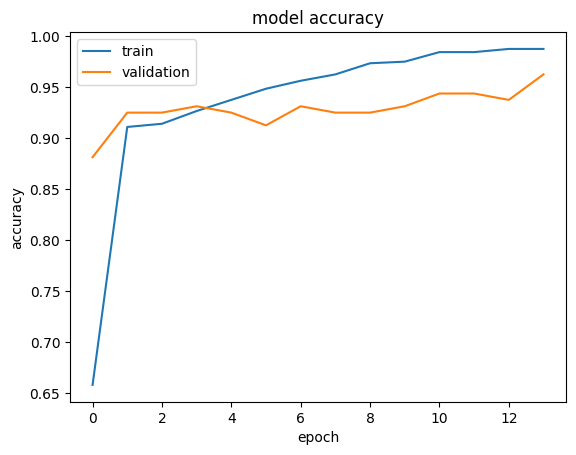

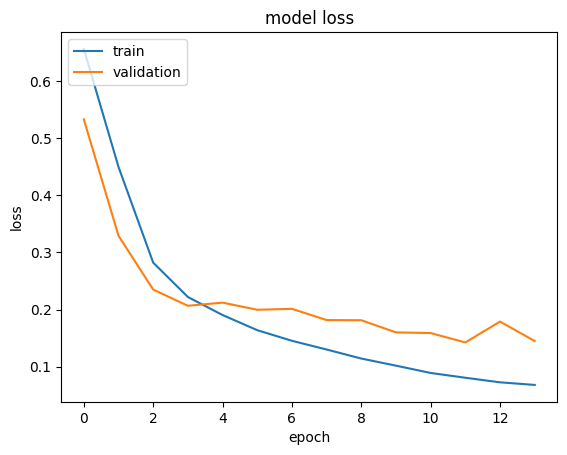

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(os.path.join(MODEL_DIR,"accuracy.png"), format='png', dpi=1000)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(os.path.join(MODEL_DIR,"loss.png"), format='png', dpi=100)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
# confusion matrix in sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import csv

#print(target_test)
y_pred = model.predict(np.array(data_test))
y_pred = np.argmax(y_pred, axis=1)

#import numpy as np
target_test_max=np.argmax(target_test, axis=1)


# confusion matrix
conf_matrix = confusion_matrix( np.array(target_test_max), y_pred)
print('Confusion matrix : \n',conf_matrix)


# guardar reporte en archivo csv
dataframe = pd.DataFrame(metrics.classification_report(np.array(target_test_max),
                                                       y_pred, digits = 4,output_dict=True)).transpose()
dataframe.to_csv(os.path.join(MODEL_DIR,"metrics.csv"),sep=',')

with open(os.path.join(MODEL_DIR,"metrics.csv"), 'a', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Confusion matrix"])
    for row in conf_matrix:
        writer.writerow(row)
    writer.writerow(["Settings"])
    writer.writerow(list(settings.keys()))
    writer.writerow(list(settings.values()))
    writer.writerow(["Notebook", BASENAME+TIMESTAMP])

7/7 [==============================] - 1s 17ms/step
Confusion matrix : 
 [[ 95   3]
 [  2 100]]


In [ ]:
##########################
# SAVE #
##########################
model.save(MODEL_NAME)

In [ ]:
##########################
# LOAD #
##########################
reconstructed_model = keras.models.load_model(MODEL_NAME)